<a href="https://colab.research.google.com/github/Ds2023/Plant_Leaf_Disease_Detection/blob/main/Plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing and importing necessary libraries**

In [1]:
pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import os
import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# **Data Sourcing and Preprocessing**

In [4]:
with ZipFile("/content/drive/MyDrive/Classroom/archive (20).zip", 'r') as zObject:

    zObject.extractall(
        path="/content/drive/MyDrive/Colab Notebooks/plant_data")

In [3]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/plant_data/plantvillage dataset/color'

**Visualizing a few data samples**

In [5]:
dg = ImageDataGenerator()

In [6]:
data = dg.flow_from_directory(dir_path, class_mode='categorical', batch_size=32)

Found 54305 images belonging to 38 classes.


In [24]:
d_swap = {v: k for k, v in data.class_indices.items()}

In [9]:
batch = data.next()

In [11]:
batch[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

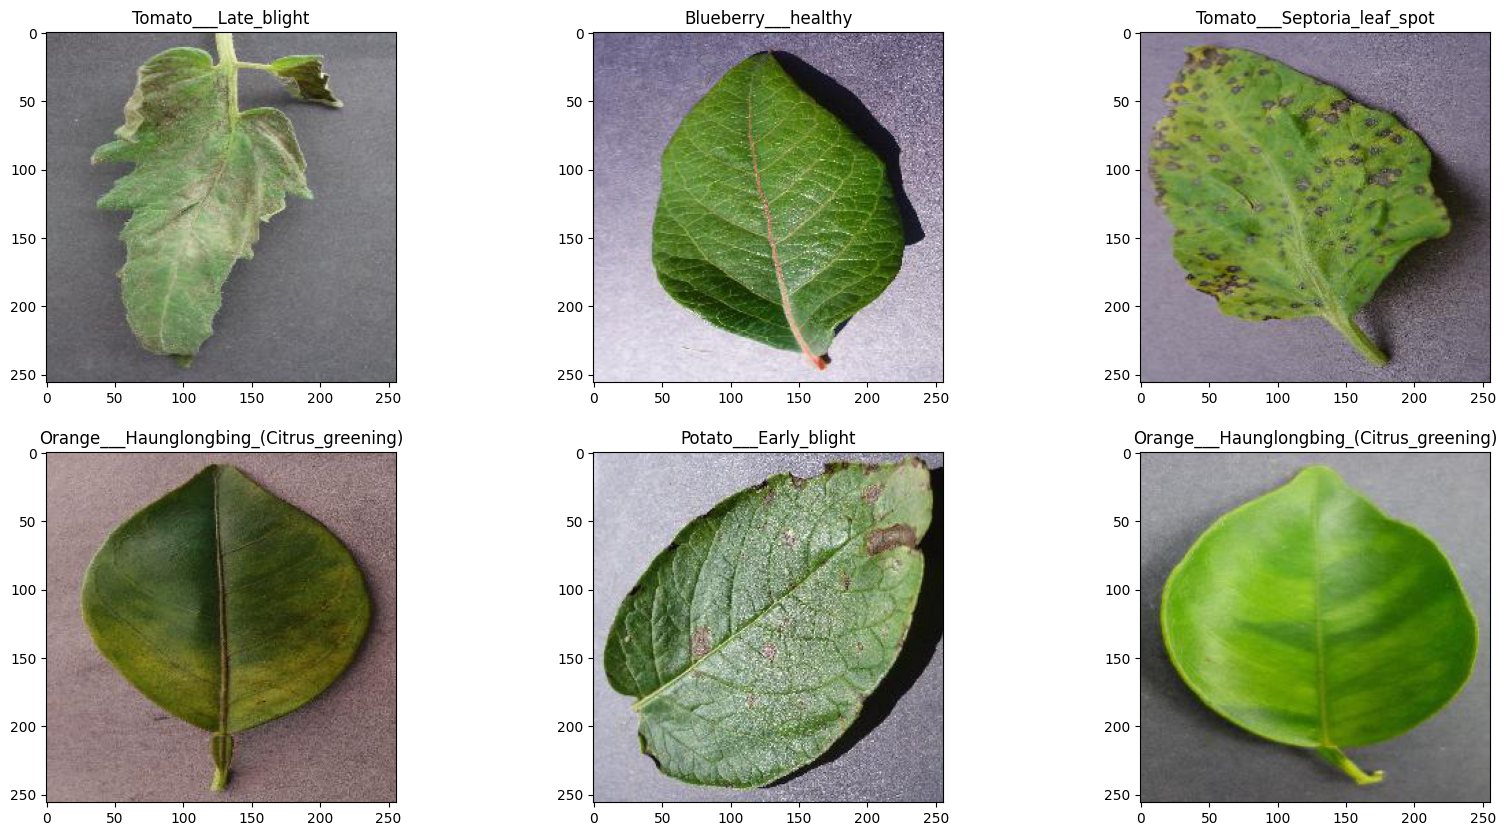

In [29]:
plt.figure(figsize=(20,10))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(batch[0][i].astype(int))
  plt.title(d_swap[np.argmax(batch[1][i].astype(int))])

Splitting the data into two datasets:


*   Train - Training and Validation
*   Test - For testing after modelling



In [5]:
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/plant_data/plantvillage dataset/color', output="Images", seed=42, ratio=(0.80,0.20))

Copying files: 54305 files [03:06, 290.77 files/s]


In [7]:
train_dir = '/content/Images/train'
test_dir = '/content/Images/val'

In [8]:
img_height = 224
img_width = 224

We'll split our train dataset into a training and validation set to assess the model fit behaviour during training.

In [9]:
train_ds = image_dataset_from_directory(train_dir,
                                        seed = 123,
                                        image_size=(img_height, img_width),
                                        validation_split=0.2,
                                        subset='training')

Found 43429 files belonging to 38 classes.
Using 34744 files for training.


In [10]:
val_ds = image_dataset_from_directory(train_dir,
                                      seed = 123,
                                      image_size=(img_height, img_width),
                                      validation_split=0.2,
                                      subset='validation')

Found 43429 files belonging to 38 classes.
Using 8685 files for validation.


# **Modelling**

We'll utilise callbacks during the training phase to stop further training once certain measures are met, in this case out metric of interest will be accuracy.

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=3 , verbose = 1)

We'll be using a sequential layer which will encompass:

*   Convolution layer: Transformation of the input for feature extraction

*   Activation layer: Introduces non_linearity to control how well the model fits our data.

*   Maxpooling layer: Creates a downsampled feature map of the most present feature in a patch.

*   Batch normalization layer: Standardizes inputs to a particular layer thus accelerating model training.

*   Dropout layer: Nullifies contribution of some neurons thus helping us prevent overfitting.





In [17]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(38, activation='softmax'))

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 224, 224, 32)     896       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 32)       

Model fitting on our training and validation sets.

In [18]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=es)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1086/1086 [==============================] - 147s 120ms/step - loss: 1.5704 - accuracy: 0.5562 - val_loss: 1.1823 - val_accuracy: 0.6588
Epoch 2/20
1086/1086 [==============================] - 130s 119ms/step - loss: 1.2233 - accuracy: 0.6472 - val_loss: 1.4643 - val_accuracy: 0.5945
Epoch 3/20
1086/1086 [==============================] - 121s 111ms/step - loss: 0.8583 - accuracy: 0.7383 - val_loss: 0.9875 - val_accuracy: 0.7085
Epoch 4/20
1086/1086 [==============================] - 121s 111ms/step - loss: 1.0476 - accuracy: 0.6920 - val_loss: 0.9785 - val_accuracy: 0.7075
Epoch 5/20
1086/1086 [==============================] - 121s 112ms/step - loss: 0.8375 - accuracy: 0.7459 - val_loss: 0.6380 - val_accuracy: 0.8098
Epoch 6/20
1086/1086 [==============================] - 122s 112ms/step - loss: 0.6629 - accuracy: 0.7956 - val_loss: 0.8165 - val_accuracy: 0.7597
Epoch 7/20
1086/1086 [==============================] - 121s 111ms/step - loss: 0.7467 - accuracy: 0.7713 - val_loss: 1.944

**Visualizing training metrics**

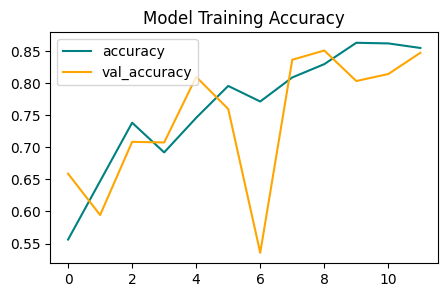

In [27]:
plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], color='teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
plt.title('Model Training Accuracy')
plt.legend(loc='upper left')
plt.show()

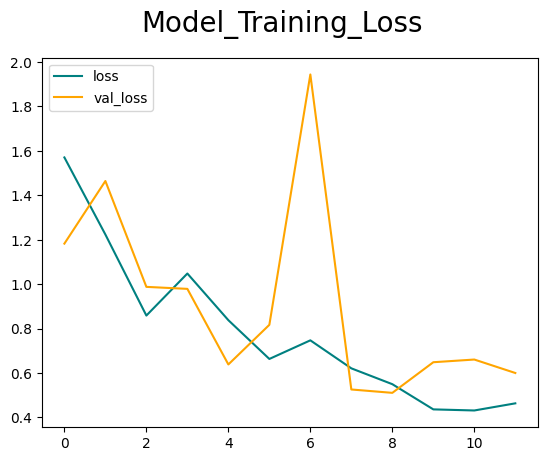

In [28]:
plt.figure(figsize=(5,5))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Model_Training_Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Evaluating the model**

In [29]:
test_ds = image_dataset_from_directory(test_dir,
                                      seed = 123,
                                      image_size=(img_height, img_width))

Found 10876 files belonging to 38 classes.


In [30]:
scores = model.evaluate(test_ds,verbose=0)

In [32]:
print('Test Accuracy: ',scores[1])
print('Test Loss: ',scores[0])

Test Accuracy:  0.8578521609306335
Test Loss:  0.5357316732406616


Our model attains a test_accuracy of 85% from a training accuracy of about 86%. This shows our that the model handled overfitting quite well.

**Visualizing predictions from our model**

In [34]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

actual label: Apple___healthy
1/1 [==============================] - 0s 216ms/step
predicted label: Apple___healthy


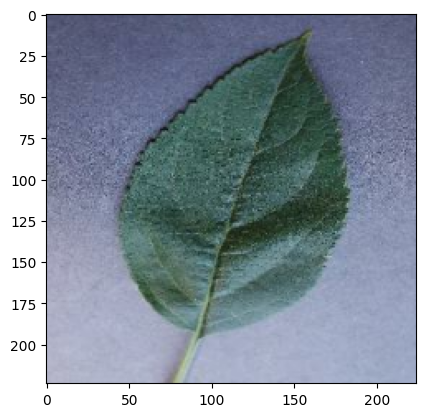

In [35]:
labels = train_ds.class_names
labels
for images_batch, labels_batch in test_ds.take(1):

    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()

    plt.imshow(image)
    print("actual label:", labels[label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [42]:
from tensorflow import expand_dims, newaxis

def predict(model, img):

    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


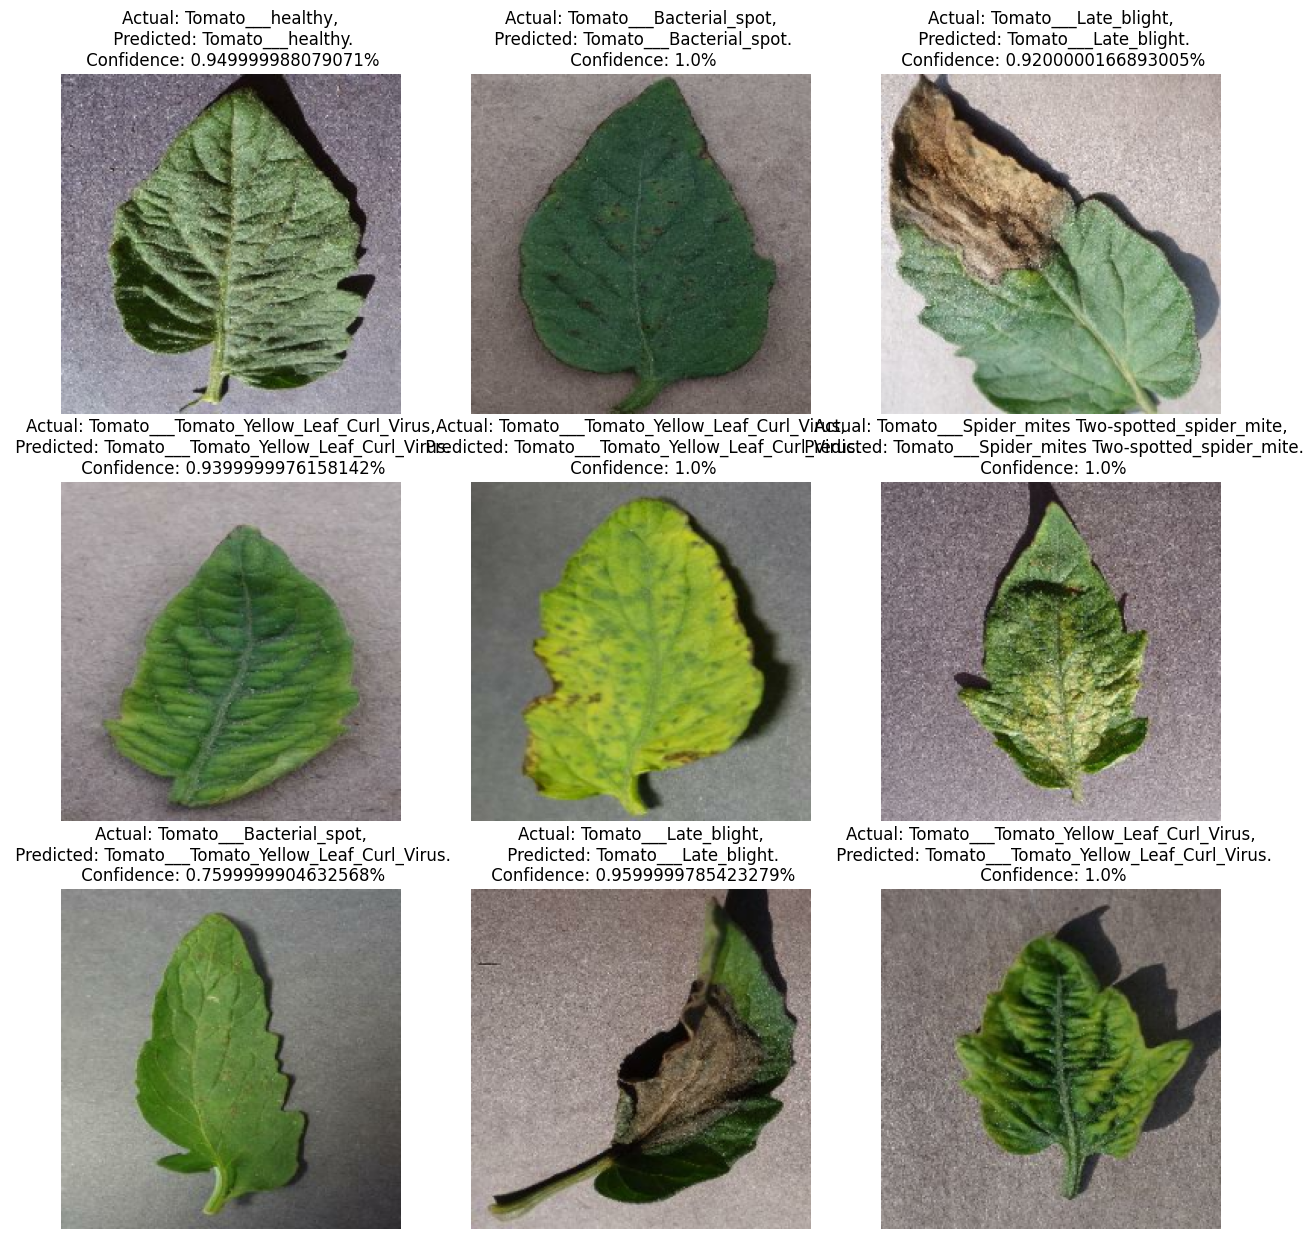

In [43]:
plt.figure(figsize=(15, 15))

for images, lbls in test_ds.take(1):
    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbls[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


We can see one misclassification of our model which corresponds to not so high confidence level (75%) as expected.

**Saving the model**

In [44]:
from tensorflow.keras.models import load_model

In [45]:
os.mkdir('models')

In [46]:
model.save(os.path.join('models','plant_disease_classification.h5'))